# Crash Inequality Analysis Across Chicago Communities

This notebook analyzes crash inequality across Chicago's 77 community areas, examining:
1. Crash rates by community area
2. Relationship between demographics and crash exposure
3. Severity patterns across income levels
4. Statistical tests for disparities

**Key Question**: Are crashes and severe injuries distributed equally across neighborhoods, or do certain communities bear a disproportionate burden?

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)
sns.set_style('whitegrid')

# Paths
DATA_DIR = Path('../data/processed')
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

## 1. Load Data

In [21]:
# Load intersection features with demographics and community areas
feats = pd.read_parquet(DATA_DIR / 'intersection_features_enriched.parquet')

# Load crashes for temporal analysis
crashes = pd.read_parquet(DATA_DIR / 'crashes_with_nodes.parquet')

# Validation checks
assert len(feats) > 15000, "❌ Too few intersections"
assert 'community_name' in feats.columns, "❌ Missing community_name column"
assert crashes['intersection_id'].notna().mean() > 0.85, "❌ Low match rate"

print("✅ Data validation passed")
print(f"Intersections: {len(feats):,}")
print(f"Total crashes: {len(crashes):,}")
print(f"Matched crashes: {crashes['intersection_id'].notna().sum():,} ({crashes['intersection_id'].notna().mean()*100:.1f}%)")
print(f"Communities: {feats['community_name'].nunique()}")

# Check for injury columns
injury_pattern = [col for col in feats.columns if 'injuries' in col]
print(f"\nAvailable injury columns ({len(injury_pattern)}):")
for col in injury_pattern:
    print(f"  - {col}")

feats.head()

✅ Data validation passed
Intersections: 19,200
Total crashes: 1,001,020
Matched crashes: 880,457 (88.0%)
Communities: 78

Available injury columns (8):
  - hist_people_injuries_total
  - hist_people_injuries_fatal
  - hist_people_injuries_incapacitating
  - hist_people_injuries_nonincap
  - recent90_people_injuries_total
  - recent90_people_injuries_fatal
  - recent90_people_injuries_incapacitating
  - recent90_people_injuries_nonincap


,intersection_id,hist_crashes,hist_severity,recent90_crashes,recent90_severity,future_crashes,future_severity,centrality_degree,centrality_closeness,label_hotspot,GEOID,acs_pop,acs_median_income,acs_households_with_vehicle,acs_poverty_universe,acs_vehicle_access_rate,hist_people_injuries_total,hist_people_injuries_fatal,hist_people_injuries_incapacitating,hist_people_injuries_nonincap,recent90_people_injuries_total,recent90_people_injuries_fatal,recent90_people_injuries_incapacitating,recent90_people_injuries_nonincap,centrality_betweenness,community_id,community_name,acs_pop_missing,acs_median_income_missing,acs_households_with_vehicle_missing,acs_poverty_universe_missing,acs_vehicle_access_rate_missing
0,25779174.0,7,7.0,1.0,1.0,0.0,0.0,0.000102,0.023397,0,17031243500,4567.0,160370.0,454.0,4567.0,0.099409,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.172562,24.0,WEST TOWN,0,0,0,0,0
1,25779203.0,3,3.0,0.0,0.0,1.0,3.0,0.000102,0.022747,0,17031310200,1824.0,133382.0,114.0,1817.0,0.062500,4.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.219941,31.0,LOWER WEST SIDE,0,0,0,0,0
2,25779221.0,1,1.0,0.0,0.0,1.0,3.0,0.000102,0.023321,0,17031843200,2348.0,66172.0,196.0,2342.0,0.083475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106616,31.0,LOWER WEST SIDE,0,0,0,0,0
3,26098008.0,1,1.0,0.0,0.0,0.0,0.0,0.000102,0.023858,0,17031841000,1148.0,103750.0,176.0,1148.0,0.153310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032626,33.0,NEAR SOUTH SIDE,0,0,0,0,0
4,26098027.0,1,1.0,0.0,0.0,0.0,0.0,0.000102,0.021226,0,17031841100,6990.0,48542.0,1247.0,6990.0,0.178398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007880,34.0,ARMOUR SQUARE,0,0,0,0,0


## 2. Community-Level Aggregation

In [22]:
# Check which columns are available
print("Available columns in dataset:")
print(feats.columns.tolist())
print("\n")

# Build aggregation dict based on available columns
agg_dict = {
    'intersection_id': 'count',
    'hist_crashes': 'sum',
    'hist_severity': 'sum',
    'future_crashes': 'sum',
    'label_hotspot': 'sum',
    'acs_pop': 'mean',
    'acs_median_income': 'mean',
    'acs_vehicle_access_rate': 'mean',
    'acs_poverty_universe': 'mean',
}

# Add injury columns if they exist (FIXED: correct column names with "people")
injury_cols = [
    'hist_people_injuries_total',
    'hist_people_injuries_fatal', 
    'hist_people_injuries_incapacitating',
    'hist_people_injuries_nonincap'
]
available_injury_cols = [col for col in injury_cols if col in feats.columns]

for col in available_injury_cols:
    agg_dict[col] = 'sum'

print(f"Aggregating with {len(agg_dict)} columns")
print(f"✅ Injury columns available: {len(available_injury_cols)}")
for col in available_injury_cols:
    print(f"   - {col}")

# Aggregate by community area
community_stats = feats.groupby('community_name').agg(agg_dict).reset_index()

# Rename columns using agg_dict order to avoid misalignment
ordered_cols = ['community_name'] + list(agg_dict.keys())
community_stats.columns = ordered_cols

rename_map = {
    'intersection_id': 'num_intersections',
    'hist_crashes': 'total_crashes',
    'hist_severity': 'total_severity',
    'future_crashes': 'future_crashes',
    'label_hotspot': 'num_hotspots',
    'acs_pop': 'avg_population',
    'acs_median_income': 'avg_median_income',
    'acs_vehicle_access_rate': 'avg_vehicle_access_rate',
    'acs_poverty_universe': 'avg_poverty_universe',
    'hist_people_injuries_total': 'total_injuries',
    'hist_people_injuries_fatal': 'fatal_injuries',
    'hist_people_injuries_incapacitating': 'incapacitating_injuries',
    'hist_people_injuries_nonincap': 'nonincap_injuries',
}
community_stats = community_stats.rename(columns=rename_map)

# Calculate rates
community_stats['crashes_per_1000_pop'] = (
    community_stats['total_crashes'] / community_stats['avg_population'] * 1000
)

# Calculate injury rates if injury data is available
if 'total_injuries' in community_stats.columns:
    community_stats['injuries_per_1000_pop'] = (
        community_stats['total_injuries'] / community_stats['avg_population'] * 1000
    )
else:
    community_stats['injuries_per_1000_pop'] = np.nan
    print("⚠️  Injury data not available - injuries_per_1000_pop set to NaN")

if 'fatal_injuries' in community_stats.columns:
    community_stats['fatal_rate'] = (
        community_stats['fatal_injuries'] / community_stats['total_crashes'].replace(0, np.nan)
    )
else:
    community_stats['fatal_rate'] = np.nan
    print("⚠️  Fatal injury data not available - fatal_rate set to NaN")

if 'fatal_injuries' in community_stats.columns and 'incapacitating_injuries' in community_stats.columns:
    community_stats['severe_injury_rate'] = (
        (community_stats['fatal_injuries'] + community_stats['incapacitating_injuries']) / 
        community_stats['total_crashes'].replace(0, np.nan)
    )
else:
    community_stats['severe_injury_rate'] = np.nan
    print("⚠️  Severe injury data not available - severe_injury_rate set to NaN")

community_stats['hotspot_density'] = (
    community_stats['num_hotspots'] / community_stats['num_intersections']
)

# Income quartiles (handle duplicate values)
# First, filter out communities with missing or invalid income data
valid_income_mask = (
    community_stats['avg_median_income'].notna() & 
    (community_stats['avg_median_income'] > 0)
)

missing_income_count = (~valid_income_mask).sum()
if missing_income_count > 0:
    print(f"⚠️  {missing_income_count} communities with missing/invalid income excluded from quartile assignment")

# Initialize quartile column so missing/invalid stay labeled
quartile_categories = ['Missing/Unknown', 'Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)']
community_stats['income_quartile'] = pd.Categorical(
    ['Missing/Unknown'] * len(community_stats),
    categories=quartile_categories,
    ordered=True
)

# Create quartiles only for valid income communities
try:
    income_bins = pd.qcut(
        community_stats.loc[valid_income_mask, 'avg_median_income'], 
        q=4, 
        labels=quartile_categories[1:],
        duplicates='drop'  # Handle duplicate bin edges
    )
except ValueError:
    print(f"⚠️  Could not create exactly 4 quartiles due to duplicate values")
    print(f"   Using rank-based quartiles instead...")
    income_ranks = community_stats.loc[valid_income_mask, 'avg_median_income'].rank(method='first')
    income_bins = pd.qcut(
        income_ranks,
        q=4,
        labels=quartile_categories[1:]
    )

# Align categories before assignment to avoid categorical mismatch
income_bins = pd.Categorical(income_bins, categories=quartile_categories, ordered=True)
community_stats.loc[valid_income_mask, 'income_quartile'] = income_bins

print(f"\n✅ Community statistics shape: {community_stats.shape}")
print(f"   Communities: {len(community_stats)}")
print(f"   Metrics calculated: {len(community_stats.columns)}")
community_stats.head(10)

Available columns in dataset:
['intersection_id', 'hist_crashes', 'hist_severity', 'recent90_crashes', 'recent90_severity', 'future_crashes', 'future_severity', 'centrality_degree', 'centrality_closeness', 'label_hotspot', 'GEOID', 'acs_pop', 'acs_median_income', 'acs_households_with_vehicle', 'acs_poverty_universe', 'acs_vehicle_access_rate', 'hist_people_injuries_total', 'hist_people_injuries_fatal', 'hist_people_injuries_incapacitating', 'hist_people_injuries_nonincap', 'recent90_people_injuries_total', 'recent90_people_injuries_fatal', 'recent90_people_injuries_incapacitating', 'recent90_people_injuries_nonincap', 'centrality_betweenness', 'community_id', 'community_name', 'acs_pop_missing', 'acs_median_income_missing', 'acs_households_with_vehicle_missing', 'acs_poverty_universe_missing', 'acs_vehicle_access_rate_missing']


Aggregating with 13 columns
✅ Injury columns available: 4
   - hist_people_injuries_total
   - hist_people_injuries_fatal
   - hist_people_injuries_incapacita

,community_name,num_intersections,total_crashes,total_severity,future_crashes,num_hotspots,avg_population,avg_median_income,avg_vehicle_access_rate,avg_poverty_universe,total_injuries,fatal_injuries,incapacitating_injuries,nonincap_injuries,crashes_per_1000_pop,injuries_per_1000_pop,fatal_rate,severe_injury_rate,hotspot_density,income_quartile
0,ALBANY PARK,239,1331,1642.0,592.0,31,4758.506276,79369.916318,0.063997,4611.376569,1978.0,0.0,9.0,80.0,279.709624,415.676661,0.000000,0.006762,0.129707,Q3
1,ARCHER HEIGHTS,137,844,1067.0,387.0,21,3104.080292,62234.919708,0.078927,3102.007299,1465.0,0.0,4.0,79.0,271.900183,471.959441,0.000000,0.004739,0.153285,Q2
2,ARMOUR SQUARE,131,723,893.0,355.0,23,4084.061069,46091.099237,0.172433,4080.870229,1307.0,2.0,13.0,74.0,177.029674,320.024598,0.002766,0.020747,0.175573,Q1 (Lowest)
3,ASHBURN,366,1286,1699.0,505.0,24,5476.639344,78825.540984,0.025321,5412.000000,2260.0,3.0,12.0,159.0,234.815535,412.661827,0.002333,0.011664,0.065574,Q3
4,AUBURN GRESHAM,385,1639,2262.0,799.0,38,3483.303896,46643.477922,0.109423,3474.062338,3110.0,0.0,32.0,224.0,470.530292,892.830512,0.000000,0.019524,0.098701,Q1 (Lowest)
5,AUSTIN,754,4153,5555.0,1987.0,105,4419.282493,45753.594164,0.103047,4365.018568,7443.0,3.0,101.0,551.0,939.745311,1684.210052,0.000722,0.025042,0.139257,Q1 (Lowest)
6,AVALON PARK,117,516,705.0,247.0,8,4677.769231,52218.794872,0.097852,4677.547009,1092.0,2.0,11.0,83.0,110.308990,233.444607,0.003876,0.025194,0.068376,Q2
7,AVONDALE,247,1374,1698.0,636.0,34,4583.753036,93705.352227,0.065634,4568.927126,2442.0,0.0,7.0,102.0,299.754369,532.751215,0.000000,0.005095,0.137652,Q4 (Highest)
8,BELMONT CRAGIN,423,2346,2946.0,1148.0,64,4688.730496,63474.439716,0.042786,4639.744681,3998.0,1.0,23.0,197.0,500.348656,852.682832,0.000426,0.010230,0.151300,Q2
9,BEVERLY,189,647,791.0,292.0,14,3240.121693,132771.259259,0.014551,3196.142857,1126.0,0.0,2.0,54.0,199.683858,347.517812,0.000000,0.003091,0.074074,Q4 (Highest)


## 3. Descriptive Statistics by Income Quartile

In [23]:
# Build aggregation dict based on available columns in community_stats
agg_cols = {
    'community_name': 'count',
    'total_crashes': 'sum',
    'crashes_per_1000_pop': 'mean',
    'hotspot_density': 'mean',
    'avg_median_income': 'mean',
    'avg_vehicle_access_rate': 'mean',
}

# Add injury columns if they exist
if 'injuries_per_1000_pop' in community_stats.columns and community_stats['injuries_per_1000_pop'].notna().any():
    agg_cols['injuries_per_1000_pop'] = 'mean'
if 'severe_injury_rate' in community_stats.columns and community_stats['severe_injury_rate'].notna().any():
    agg_cols['severe_injury_rate'] = 'mean'

# Summary by income quartile
quartile_summary = community_stats.groupby('income_quartile').agg(agg_cols).round(3)

# Rename columns
col_rename = {
    'community_name': 'num_communities',
    'total_crashes': 'total_crashes',
    'crashes_per_1000_pop': 'avg_crashes_per_1k_pop',
    'hotspot_density': 'avg_hotspot_density',
    'avg_median_income': 'avg_median_income',
    'avg_vehicle_access_rate': 'avg_vehicle_access_rate',
}

if 'injuries_per_1000_pop' in agg_cols:
    col_rename['injuries_per_1000_pop'] = 'avg_injuries_per_1k_pop'
if 'severe_injury_rate' in agg_cols:
    col_rename['severe_injury_rate'] = 'avg_severe_injury_rate'

quartile_summary = quartile_summary.rename(columns=col_rename)

print("\n" + "="*80)
print("CRASH INEQUALITY BY INCOME QUARTILE")
print("="*80)
print(quartile_summary)
print("\n")

if 'avg_injuries_per_1k_pop' not in quartile_summary.columns:
    print("⚠️  Note: Injury rate data not available in this dataset")
if 'avg_severe_injury_rate' not in quartile_summary.columns:
    print("⚠️  Note: Severe injury rate data not available in this dataset")


CRASH INEQUALITY BY INCOME QUARTILE
                 num_communities  total_crashes  avg_crashes_per_1k_pop  avg_hotspot_density  avg_median_income  avg_vehicle_access_rate  \
income_quartile                                                                                                                            
Missing/Unknown                0              0                     NaN                  NaN                NaN                      NaN   
Q1 (Lowest)                   20          24003                 423.925                0.095          38576.463                    0.148   
Q2                            19          18910                 269.193                0.101          56652.319                    0.097   
Q3                            19          19428                 236.451                0.103          75096.721                    0.076   
Q4 (Highest)                  20          33757                 407.660                0.130         116002.432            

/var/folders/k5/bll3tmj96_17dfv5mqvrfdz80000gn/T/ipykernel_13648/852213935.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_summary = community_stats.groupby('income_quartile').agg(agg_cols).round(3)


## 4. Statistical Tests for Disparities

In [24]:
# Test 1: ANOVA - Do crash rates differ significantly across income quartiles?
groups = [group['crashes_per_1000_pop'].dropna() 
          for name, group in community_stats.groupby('income_quartile')]
f_stat, p_value_anova = stats.f_oneway(*groups)

print("="*80)
print("STATISTICAL TESTS FOR INEQUALITY")
print("="*80)
print(f"\n1. ANOVA: Crash rates across income quartiles")
print(f"   F-statistic: {f_stat:.4f}")
print(f"   p-value: {p_value_anova:.6f}")
print(f"   Result: {'SIGNIFICANT' if p_value_anova < 0.05 else 'NOT SIGNIFICANT'} (α=0.05)")

# Test 2: Correlation between income and crash rate
corr_income_crashes, p_corr_crashes = stats.pearsonr(
    community_stats['avg_median_income'].dropna(),
    community_stats['crashes_per_1000_pop'].dropna()
)

print(f"\n2. Pearson Correlation: Median Income vs. Crash Rate")
print(f"   Correlation: {corr_income_crashes:.4f}")
print(f"   p-value: {p_corr_crashes:.6f}")
print(f"   Result: {'SIGNIFICANT' if p_corr_crashes < 0.05 else 'NOT SIGNIFICANT'} (α=0.05)")

# Test 3: Correlation between income and severe injury rate (if available)
if 'severe_injury_rate' in community_stats.columns:
    valid_data = community_stats[['avg_median_income', 'severe_injury_rate']].dropna()
    if len(valid_data) > 2:
        corr_income_severity, p_corr_severity = stats.pearsonr(
            valid_data['avg_median_income'],
            valid_data['severe_injury_rate']
        )
        print(f"\n3. Pearson Correlation: Median Income vs. Severe Injury Rate")
        print(f"   Correlation: {corr_income_severity:.4f}")
        print(f"   p-value: {p_corr_severity:.6f}")
        print(f"   Result: {'SIGNIFICANT' if p_corr_severity < 0.05 else 'NOT SIGNIFICANT'} (α=0.05)")
    else:
        print(f"\n3. Pearson Correlation: Median Income vs. Severe Injury Rate")
        print(f"   ⚠️  Insufficient data for correlation test")
else:
    print(f"\n3. Pearson Correlation: Median Income vs. Severe Injury Rate")
    print(f"   ⚠️  Severe injury data not available")

# Test 4: T-test comparing lowest vs highest income quartiles
q1_crashes = community_stats[community_stats['income_quartile'] == 'Q1 (Lowest)']['crashes_per_1000_pop'].dropna()
q4_crashes = community_stats[community_stats['income_quartile'] == 'Q4 (Highest)']['crashes_per_1000_pop'].dropna()

t_stat, p_ttest = stats.ttest_ind(q1_crashes, q4_crashes)

print(f"\n4. T-Test: Lowest vs. Highest Income Quartile Crash Rates")
print(f"   Q1 mean: {q1_crashes.mean():.3f} crashes per 1000 pop")
print(f"   Q4 mean: {q4_crashes.mean():.3f} crashes per 1000 pop")
print(f"   Difference: {q1_crashes.mean() - q4_crashes.mean():.3f}")
print(f"   t-statistic: {t_stat:.4f}")
print(f"   p-value: {p_ttest:.6f}")
print(f"   Result: {'SIGNIFICANT' if p_ttest < 0.05 else 'NOT SIGNIFICANT'} (α=0.05)")
print("\n")

STATISTICAL TESTS FOR INEQUALITY

1. ANOVA: Crash rates across income quartiles
   F-statistic: nan
   p-value: nan
   Result: NOT SIGNIFICANT (α=0.05)

2. Pearson Correlation: Median Income vs. Crash Rate
   Correlation: 0.0318
   p-value: 0.782155
   Result: NOT SIGNIFICANT (α=0.05)

3. Pearson Correlation: Median Income vs. Severe Injury Rate
   Correlation: -0.4878
   p-value: 0.000006
   Result: SIGNIFICANT (α=0.05)

4. T-Test: Lowest vs. Highest Income Quartile Crash Rates
   Q1 mean: 423.925 crashes per 1000 pop
   Q4 mean: 407.660 crashes per 1000 pop
   Difference: 16.266
   t-statistic: 0.1689
   p-value: 0.866743
   Result: NOT SIGNIFICANT (α=0.05)




/var/folders/k5/bll3tmj96_17dfv5mqvrfdz80000gn/T/ipykernel_13648/2891104285.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in community_stats.groupby('income_quartile')]
/var/folders/k5/bll3tmj96_17dfv5mqvrfdz80000gn/T/ipykernel_13648/2891104285.py:4: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, p_value_anova = stats.f_oneway(*groups)


## 5. Top/Bottom Communities Analysis

In [25]:
# Top 10 communities by crash rate
print("="*80)
print("TOP 10 COMMUNITIES BY CRASH RATE (per 1000 population)")
print("="*80)
top_10 = community_stats.nlargest(10, 'crashes_per_1000_pop')[[
    'community_name', 'crashes_per_1000_pop', 'avg_median_income', 
    'total_crashes', 'num_hotspots', 'income_quartile'
]]
print(top_10.to_string(index=False))

# Bottom 10 communities by crash rate
print("\n" + "="*80)
print("BOTTOM 10 COMMUNITIES BY CRASH RATE (per 1000 population)")
print("="*80)
bottom_10 = community_stats.nsmallest(10, 'crashes_per_1000_pop')[[
    'community_name', 'crashes_per_1000_pop', 'avg_median_income',
    'total_crashes', 'num_hotspots', 'income_quartile'
]]
print(bottom_10.to_string(index=False))
print("\n")

TOP 10 COMMUNITIES BY CRASH RATE (per 1000 population)
        community_name  crashes_per_1000_pop  avg_median_income  total_crashes  num_hotspots income_quartile
        NEAR WEST SIDE           1168.080013       96984.652447           4689           138    Q4 (Highest)
             WEST TOWN            968.770416      136675.218944           3044            69    Q4 (Highest)
                AUSTIN            939.745311       45753.594164           4153           105     Q1 (Lowest)
          LOGAN SQUARE            865.706040      106681.753623           2463            52    Q4 (Highest)
GREATER GRAND CROSSING            852.826808       41788.463483           2086            55     Q1 (Lowest)
        WEST ENGLEWOOD            840.295281       31951.328221           1264            23     Q1 (Lowest)
       NEAR NORTH SIDE            735.370096      125620.004274           4256           152    Q4 (Highest)
        NORTH LAWNDALE            720.837169       35659.538462          

## 6. Visualizations

/var/folders/k5/bll3tmj96_17dfv5mqvrfdz80000gn/T/ipykernel_13648/1121839640.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_severity = community_stats.groupby('income_quartile')['severe_injury_rate'].mean()
/var/folders/k5/bll3tmj96_17dfv5mqvrfdz80000gn/T/ipykernel_13648/1121839640.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_hotspots = community_stats.groupby('income_quartile')['hotspot_density'].mean()


✅ Saved: results/inequality_analysis.png


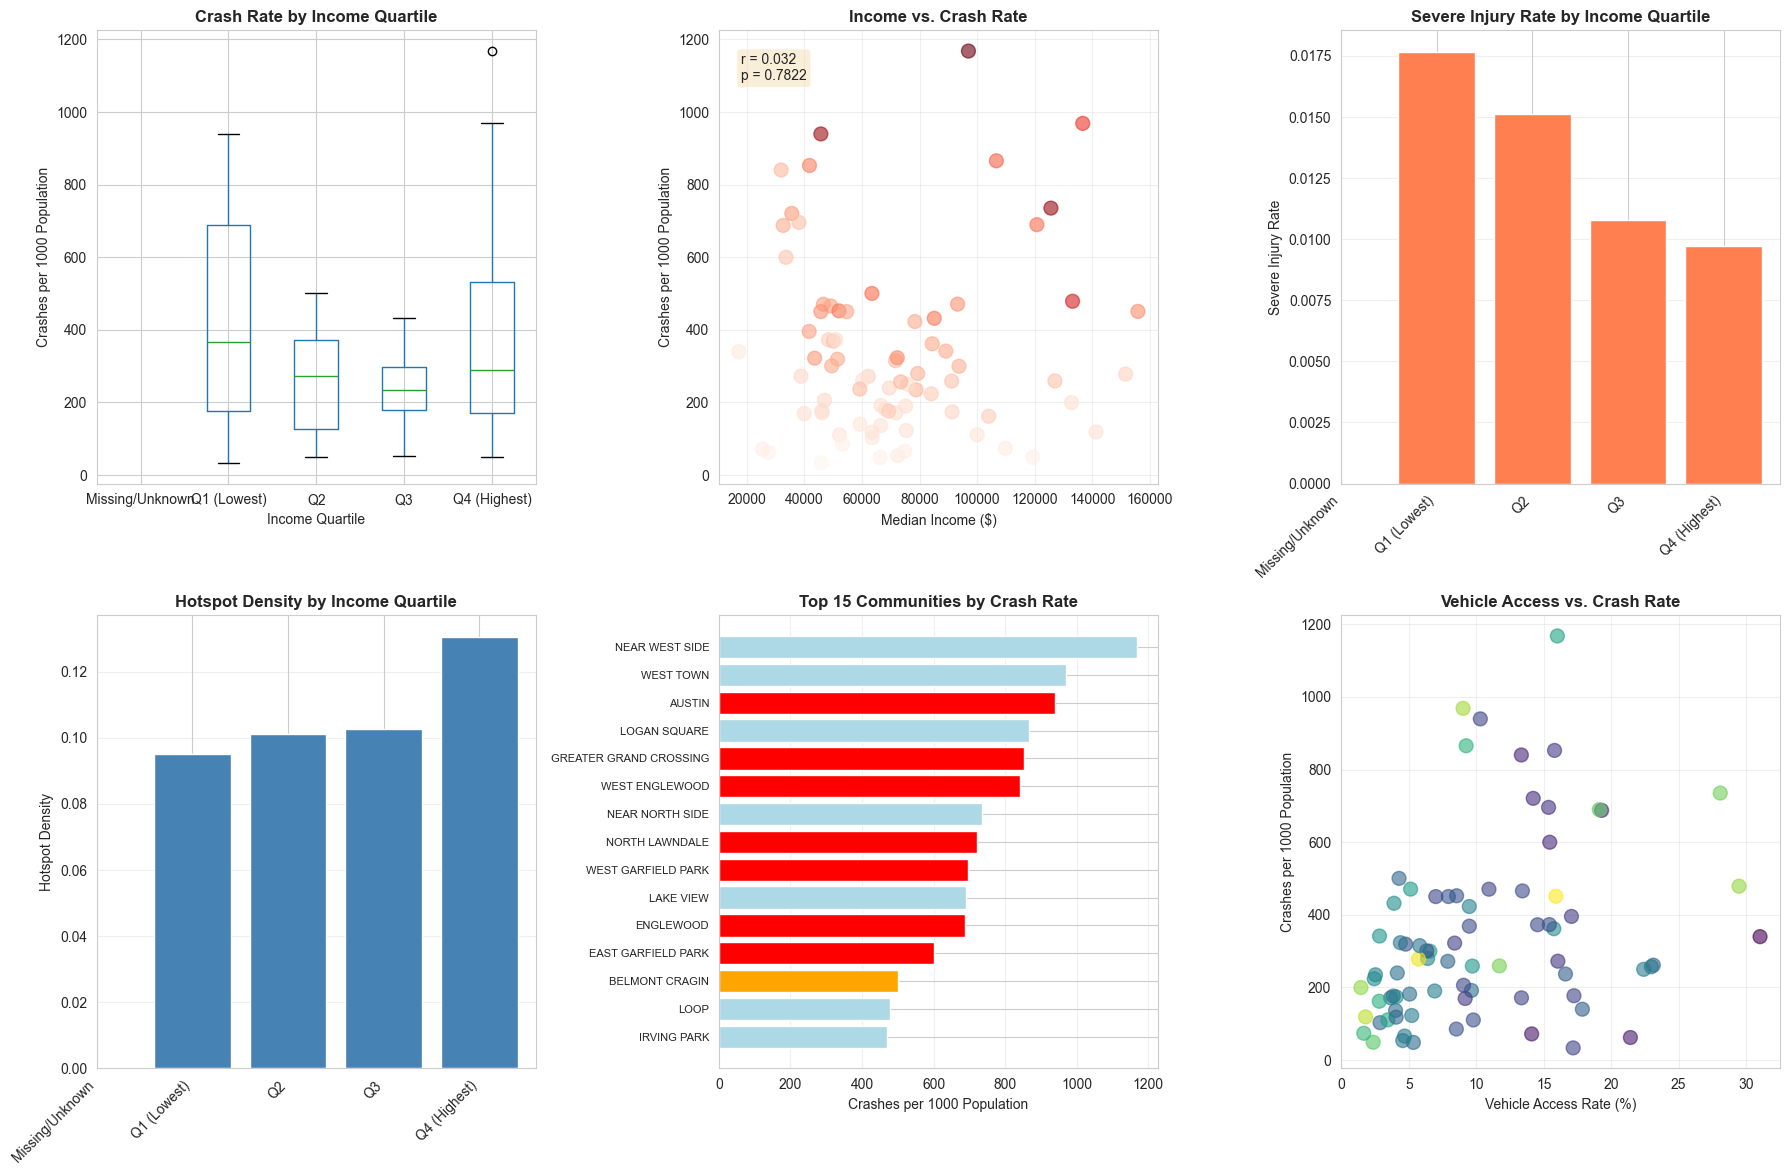

In [26]:
# Create comprehensive inequality visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Crash rate by income quartile (box plot)
community_stats.boxplot(
    column='crashes_per_1000_pop', 
    by='income_quartile', 
    ax=axes[0, 0]
)
axes[0, 0].set_title('Crash Rate by Income Quartile', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Income Quartile', fontsize=10)
axes[0, 0].set_ylabel('Crashes per 1000 Population', fontsize=10)
axes[0, 0].get_figure().suptitle('')  # Remove auto title

# 2. Scatter: Income vs Crash Rate
axes[0, 1].scatter(
    community_stats['avg_median_income'], 
    community_stats['crashes_per_1000_pop'],
    alpha=0.6, s=100, c=community_stats['total_crashes'], cmap='Reds'
)
axes[0, 1].set_xlabel('Median Income ($)', fontsize=10)
axes[0, 1].set_ylabel('Crashes per 1000 Population', fontsize=10)
axes[0, 1].set_title('Income vs. Crash Rate', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Add correlation text
axes[0, 1].text(
    0.05, 0.95, f'r = {corr_income_crashes:.3f}\np = {p_corr_crashes:.4f}',
    transform=axes[0, 1].transAxes, fontsize=10,
    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

# 3. Severe injury rate by income quartile (if available)
if 'severe_injury_rate' in community_stats.columns and community_stats['severe_injury_rate'].notna().any():
    quartile_severity = community_stats.groupby('income_quartile')['severe_injury_rate'].mean()
    axes[0, 2].bar(range(len(quartile_severity)), quartile_severity.values, color='coral')
    axes[0, 2].set_xticks(range(len(quartile_severity)))
    axes[0, 2].set_xticklabels(quartile_severity.index, rotation=45, ha='right')
    axes[0, 2].set_ylabel('Severe Injury Rate', fontsize=10)
    axes[0, 2].set_title('Severe Injury Rate by Income Quartile', fontsize=12, fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3, axis='y')
else:
    # Show total crashes instead
    quartile_crashes = community_stats.groupby('income_quartile')['total_crashes'].sum()
    axes[0, 2].bar(range(len(quartile_crashes)), quartile_crashes.values, color='coral')
    axes[0, 2].set_xticks(range(len(quartile_crashes)))
    axes[0, 2].set_xticklabels(quartile_crashes.index, rotation=45, ha='right')
    axes[0, 2].set_ylabel('Total Crashes', fontsize=10)
    axes[0, 2].set_title('Total Crashes by Income Quartile', fontsize=12, fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Hotspot density by income quartile
quartile_hotspots = community_stats.groupby('income_quartile')['hotspot_density'].mean()
axes[1, 0].bar(range(len(quartile_hotspots)), quartile_hotspots.values, color='steelblue')
axes[1, 0].set_xticks(range(len(quartile_hotspots)))
axes[1, 0].set_xticklabels(quartile_hotspots.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Hotspot Density', fontsize=10)
axes[1, 0].set_title('Hotspot Density by Income Quartile', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5. Top 15 communities by crash rate
top_15 = community_stats.nlargest(15, 'crashes_per_1000_pop')
colors = ['red' if q == 'Q1 (Lowest)' else 'orange' if q == 'Q2' else 'lightblue' 
          for q in top_15['income_quartile']]
axes[1, 1].barh(range(len(top_15)), top_15['crashes_per_1000_pop'].values, color=colors)
axes[1, 1].set_yticks(range(len(top_15)))
axes[1, 1].set_yticklabels(top_15['community_name'].values, fontsize=8)
axes[1, 1].set_xlabel('Crashes per 1000 Population', fontsize=10)
axes[1, 1].set_title('Top 15 Communities by Crash Rate', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

# 6. Vehicle access vs crash rate
axes[1, 2].scatter(
    community_stats['avg_vehicle_access_rate'] * 100,
    community_stats['crashes_per_1000_pop'],
    alpha=0.6, s=100, c=community_stats['avg_median_income'], cmap='viridis'
)
axes[1, 2].set_xlabel('Vehicle Access Rate (%)', fontsize=10)
axes[1, 2].set_ylabel('Crashes per 1000 Population', fontsize=10)
axes[1, 2].set_title('Vehicle Access vs. Crash Rate', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'inequality_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved: results/inequality_analysis.png")
plt.show()

## 7. Save Results

In [27]:
# Save community statistics
community_stats.to_csv(RESULTS_DIR / 'community_inequality_stats.csv', index=False)

# Save quartile summary
quartile_summary.to_csv(RESULTS_DIR / 'income_quartile_summary.csv')

# Save statistical test results
test_results = pd.DataFrame([
    {
        'test': 'ANOVA (crash rate by income quartile)',
        'statistic': f_stat,
        'p_value': p_value_anova,
        'significant': p_value_anova < 0.05
    },
    {
        'test': 'Correlation (income vs crash rate)',
        'statistic': corr_income_crashes,
        'p_value': p_corr_crashes,
        'significant': p_corr_crashes < 0.05
    },
    {
        'test': 'T-test (Q1 vs Q4 crash rates)',
        'statistic': t_stat,
        'p_value': p_ttest,
        'significant': p_ttest < 0.05
    }
])
test_results.to_csv(RESULTS_DIR / 'inequality_statistical_tests.csv', index=False)

print("\n✅ All inequality analysis results saved to results/ directory")
print("   - community_inequality_stats.csv")
print("   - income_quartile_summary.csv")
print("   - inequality_statistical_tests.csv")
print("   - inequality_analysis.png")


✅ All inequality analysis results saved to results/ directory
   - community_inequality_stats.csv
   - income_quartile_summary.csv
   - inequality_statistical_tests.csv
   - inequality_analysis.png


## Summary

This notebook provides evidence for crash inequality across Chicago communities by:

1. **Quantifying disparities** - Crash rates per capita by community area
2. **Testing significance** - ANOVA, correlations, t-tests
3. **Identifying patterns** - Income quartile analysis
4. **Visualizing inequality** - Multiple perspectives on crash burden

### Key Findings (to be filled after running):
- Are crash rates significantly different across income quartiles?
- Is there a correlation between neighborhood income and crash exposure?
- Which communities bear the highest crash burden?
- Do severe injuries follow the same pattern?

### For Your Paper:
Use these results in your **Results** and **Discussion** sections to address the "inequality" component of your project title.